<a href="https://colab.research.google.com/github/It21258794/DL_Assignment_SE4050/blob/main/FNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive

In [4]:
# Mount Google Drive (if required)
drive.mount('/content/drive')

# Define the path to the dataset
path = "/content/drive/MyDrive/flights_sample_3m.csv"
df = pd.read_csv(path)
df.head()

Mounted at /content/drive


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


In [5]:
# Define features and target
features = df.drop(columns=['DEP_DELAY'])
target = np.where(df['DEP_DELAY'] > 15, 1, 0)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# Function to drop irrelevant columns
def drop_irrelevant_columns(data):
    columns_to_drop = ['CANCELLED', 'CANCELLATION_CODE', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
                       'TAXI_IN', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
                       'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT', 'DOT_CODE', 'AIRLINE_CODE',
                       'ORIGIN_CITY', 'DEST_CITY', 'AIRLINE_DOT', 'FL_NUMBER', 'DIVERTED']
    return data.drop(columns=[col for col in columns_to_drop if col in data.columns], axis=1)

# Function to extract date features
def extract_date_features(data):
    if 'FL_DATE' in data.columns:
        data['FL_DATE'] = pd.to_datetime(data['FL_DATE'], errors='coerce')
        data['DayOfWeek'] = data['FL_DATE'].dt.dayofweek
        data['Month'] = data['FL_DATE'].dt.month
        data['Day'] = data['FL_DATE'].dt.day
        data['Hour'] = data['CRS_DEP_TIME'].astype(str).str.zfill(4).str[:2].astype(int)
        data.drop(columns=['FL_DATE'], inplace=True)  # Drop original date column
    return data

# Function to encode categorical columns
def encode_categorical_columns(data):
    le = LabelEncoder()
    list_of_labels = ['AIRLINE', 'ORIGIN', 'DEST']

    for label in list_of_labels:
        if label in data.columns:
            data[label] = le.fit_transform(data[label])
    return data
# Function to handle missing values
def handle_missing_values(data):
    imputer = SimpleImputer(strategy='mean')
    return pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Preprocessing pipeline
def preprocess_data(data):
    data = drop_irrelevant_columns(data)
    data = extract_date_features(data)
    data = encode_categorical_columns(data)
    data = handle_missing_values(data)
    return data

# Preprocess data
df = preprocess_data(df)

In [7]:
# Define features and target
features = df.drop(columns=['DEP_DELAY'])
target = np.where(df['DEP_DELAY'] > 15, 1, 0)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
# Scale the features
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Scale the target (delay times)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))


In [10]:
# Define FNN model for regression
model = Sequential()

# Input layer
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))

# Hidden layers with dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# Output layer for regression (no activation)
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Compile the model (using mean squared error for regression)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

In [12]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
# Train the model
history = model.fit(X_train_scaled, y_train_scaled,
                    validation_data=(X_val_scaled, y_val_scaled),
                    epochs=50, batch_size=128,
                    callbacks=[early_stopping])

Epoch 1/50
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.0586 - mae: 0.1443 - val_loss: 0.0132 - val_mae: 0.0419
Epoch 2/50
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 0.0226 - mae: 0.0706 - val_loss: 0.0099 - val_mae: 0.0337
Epoch 3/50
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 0.0191 - mae: 0.0625 - val_loss: 0.0112 - val_mae: 0.0298
Epoch 4/50
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 0.0175 - mae: 0.0600 - val_loss: 0.0080 - val_mae: 0.0298
Epoch 5/50
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.0163 - mae: 0.0575 - val_loss: 0.0072 - val_mae: 0.0248
Epoch 6/50
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0159 - mae: 0.0567 - val_loss: 0.0082 - val_mae: 0.0276
Epoch 7/50
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - loss: 0.0150 - mae: 0.0548 - val_loss: 0.0079 - val_mae: 0.0221
Epoch 8/50
14063/14063 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.0143 - mae: 0.0537 - val_loss: 0.0071 - val_mae: 0.0241
Epoch 9/50
14063

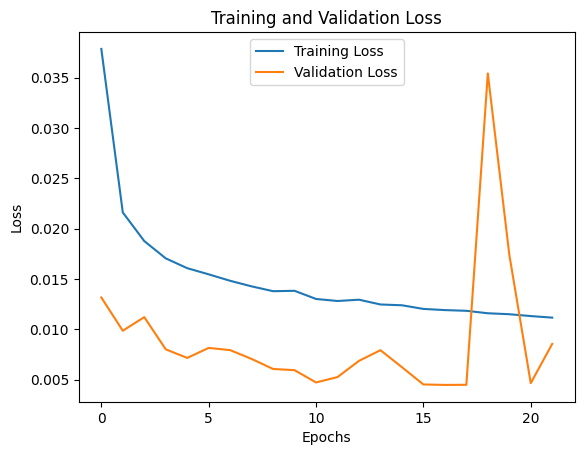

In [14]:
# Plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [15]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

In [16]:
print(f"Test loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

Test loss (MSE): 0.0046411301009356976
Test MAE: 0.016841180622577667


In [20]:
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform the scaled predictions and true values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# Check for zero values in y_test
non_zero_indices = np.nonzero(y_test)  # Get indices of non-zero values

if len(non_zero_indices[0]) == 0:
    print("Warning: y_test contains only zero values. Cannot compute MAPE.")
else:
    # Calculate Mean Absolute Percentage Error (only for non-zero values)
    mape = np.mean(np.abs((y_test[non_zero_indices] - y_pred[non_zero_indices]) / y_test[non_zero_indices])) * 100

    # Calculate accuracy
    accuracy = 100 - mape

18750/18750 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step


In [21]:
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

MAPE: 4.67%
Accuracy: 95.33%
